In [47]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [48]:
#Load data into notebook
datafile = "frost_data.txt"
df = pd.read_table(datafile, sep=" ", header=0)

In [49]:
#Separates the two targets (and tprev) from the features
y_frostobs = df['frostobs']
y_tobs = df['tobs']

t_prev = df['tprev']

X = df.drop(['frostobs', 'tobs', 'tprev'], 1)
n_samples, n_features = X.shape

(array([ 10268.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   1715.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

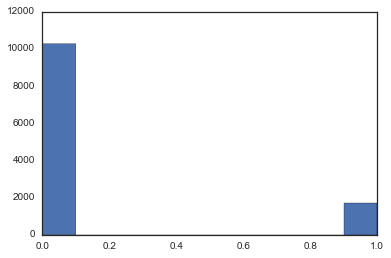

In [50]:
plt.hist(y_frostobs)

**Data for frost is not balanced, need to work around this**

(array([    7.,    61.,   175.,   733.,  2248.,  3508.,  3466.,  1501.,
          272.,    12.]),
 array([-18.20000076, -14.06000061,  -9.92000046,  -5.78000031,
         -1.64000015,   2.5       ,   6.64000015,  10.78000031,
         14.92000046,  19.06000061,  23.20000076]),
 <a list of 10 Patch objects>)

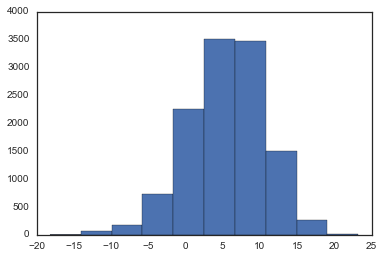

In [51]:
plt.hist(y_tobs)

## Checking correlation between variables

In [52]:
#Seaborn needs to be installed to run this code
def plot_heat_matrix(method):
    sns.set(style="white")
    corr = df.corr(method)

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                square=True, xticklabels=2, yticklabels=2,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

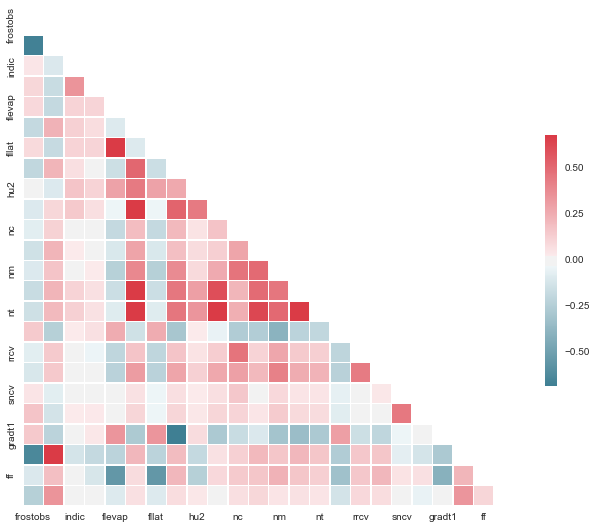

In [53]:
plot_heat_matrix("pearson")

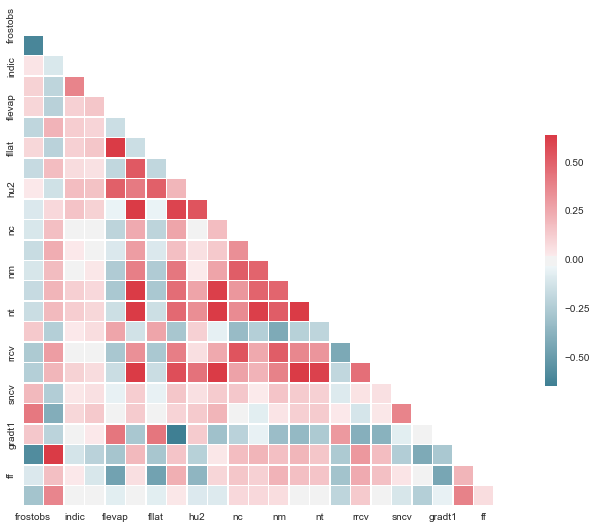

In [54]:
plot_heat_matrix("spearman")

These matrices helps us visualize the correlation between variables and the targets (frostobs is the first column, and tobs is the second columns). Not surprisingly, the two targets have a negative correlation (higher temperatures mean less chance of a frost).

The first matrix is built using Pearson's correlation, which tests if two variables are linearly correlated or not. The second one uses Spearman's correlation, which checks for monotonic relationships between the variables, linear or not. This is useful to have an intuition about what kinds of relationships are present between variables.

An example of what we might infer from these matrices is for the frostobs-snge relationship (first column, fifth row going up). By looking at the Pearson matrix, we see that the correlation between these two variables is not that strong, only mildly linear. However, the correlation is stronger when looking at the Spearman matrix. This tells us that some kind of relationship might exist between these two variables, but it is likely not linear (this is not unexpected either, since we're likely to see more snow in the presence of a frost).

## Scatter matrix for frost (small example)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000022B9CE10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000150DFE10>]], dtype=object)

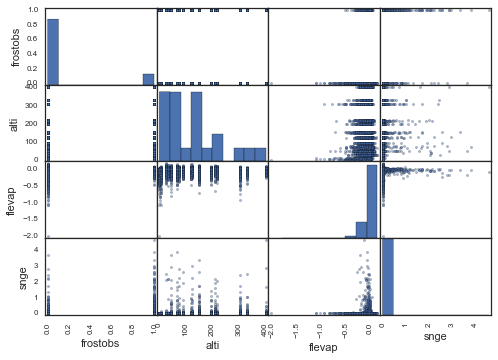

In [55]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df[['frostobs','alti', 'flevap', 'snge']])

Since we're dealing with lots of variables, only a small scatter matrix is being used, for illustration. The scatter matrix might give us even more intuitions about the relationships between variables.

Also, we can see that the scales used for each variable vary a lot. So it might be worthwhile to normalize our data later on, since this might affect our results depending on the model used.

## Check if any features have a single value

Features with a single value don't give us any information, so we can get rid of them

In [56]:
for i in range(n_features):
    if len(np.unique(X.iloc[:, i])) == 0:
        print X.columns[i]

For this problem, however, all our features have at least two values, so none were deleted.

**Alternatively**, a low variance filter can be used, to eliminate features that have a variance below a given threshold.

## Treating categorical variables
By looking at the data, we can identify 5 categorical variables: indic, name, date, month and ddf.

The variables 'indic' and 'name' are actually one and the same, since a name is always linked to a single id and vice-versa. So we can eliminate one of the two and leave the other.<br>
For the sake of simplicity however, for this first attempt, I'm going to consider that the appearance or not of a frost (and the temperature) will depend on the other weather variables available, and not on the id of the station itself (since it's just an identifier).

The 'date' variable can be separated into three parts: year, month and day (other separations are possible, like seasons for example, but year, month and day are more common). 
Since the weather tends to have a cycle over the course of a year, analyzing each year individually will probably not give us any valuable information, unless we're analyzing the changes over the years, which doesn't seem to be the case. So, again, to make it simpler, we will not consider each year individually. <br>
We already have a 'month' variable, so that is redundant. <br>
Analyzing each day could also be interesting, but, again, to make it simpler, we will consider that most of the information is already contained inside each month, and so will use only the month of the year (and thus get rid of the 'date' variable, using only 'month')<br>

'ddf' seems to be a valuable variable, and there doesn't seem to be any reason to get rid of it (it also won't give us that many new features since it has few categories, so dimensionality is not a problem).

With all that in mind we have:

In [57]:
#Get rid of indic, name, and date
X = X.drop(['indic', 'name', 'date'], 1)

#Transform other categorical variables into dummy variables
ddf_dummies = pd.get_dummies(X.ddf)
month_dummies = pd.get_dummies(X.month)
X = X.drop(['month', 'ddf'], 1)
X = pd.concat([X, ddf_dummies, month_dummies], axis=1)

## Getting test set
Now we will get 20% of the data for test. We will do this twice, once for the regression problem (temperature), and one for the classification problem (frost).

To optimize this, a single target vector (with two columns) could be used, but to make the problem a little more readable, we will call train_test_split twice, for each problem (not a problem here since our data is not too large, but something to keep in mind with bigger datasets where each small detail counts).

In [58]:
#Use train_test_split to separate the data if necessary
from sklearn.model_selection import train_test_split

X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    X, y_tobs, test_size=0.20)
X_frost_train, X_frost_test, y_frost_train, y_frost_test = train_test_split(
    X, y_frostobs, test_size=0.20)

## Building a first model

In [59]:
#Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_frost_train = scaler.fit_transform(X_frost_train)
X_frost_test = scaler.transform(X_frost_test)

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(n_estimators=300, class_weight='balanced')
clf.fit(X_frost_train, y_frost_train)
y_frost_pred = clf.predict(X_frost_test)

print "Accuracy score: " + str(accuracy_score(y_frost_test, y_frost_pred))
print "F-score: " + str(f1_score(y_frost_test, y_frost_pred))

print "Confusion matrix: "
print confusion_matrix(y_frost_test, y_frost_pred)

Accuracy score: 0.920317062995
F-score: 0.671256454389
Confusion matrix: 
[[2011   34]
 [ 157  195]]


By looking at the accuracy score alone, we would think the algorithm works really well. However, we must remember the classes are unbalanced, and so the accuracy might give us a wrong idea of the result. By looking at the F1-score and the confusion matrix we see that, for days without frost, the model works really well. But this is the class that is most present in our data. For days with actual frost, the result is not as satisfactory. While 196 days with frost were correctly classified, 157 were not, which is a considerable number of mistakes.

To improve this score, changing the *class_weight* attribute of the RandomForestClassifier might help, as well as taking a training set with more balanced classes. Another option would be to give weights to the predictions of the Random Forest. Usually, if a class has a probability higher than 0.5 (as given by *predict_proba*, it is chosen). We can manually change this threshold to better reflect the imbalance of the classes (this could be chosen by cross-validation).

In [61]:
#Scaling
scaler = StandardScaler()
X_temp_train = scaler.fit_transform(X_temp_train)
X_temp_test = scaler.transform(X_temp_test)

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

clf = RandomForestRegressor(n_estimators=300)
clf.fit(X_temp_train, y_temp_train)
y_temp_pred = clf.predict(X_temp_test)

mean_squared_error(y_temp_test, y_temp_pred)

7.5741073977628206

In [68]:
mean_squared_error(t_prev[y_temp_test.index], y_tobs[y_temp_test.index])

3.2693635637478424

We see that, for the same indexes predicted using the model, the *t_prev* predictions had a better result than the RandomForestRegressor. Which is not surprising, since trying different models, doing cross-validation and fine-tuning the parameters is still necessary, and lots can still be improved.

## Conclusion

More exploration of the data is necessary to have a better idea of the existing relationships. Making more graphs to explore the relationships between the variables, and analyzing the scatter matrix more closely could prove valuable.

Manual exploration of the data might also prove useful. That is, manually looking at all the descriptions and trying to infer correlations/causality between the variables. This can be useful to get rid of redundant information present in several variables. However, to do this, it's essential to have some knowledge of the problem, which would require some reading about the effects of pressure, altitude and other factors on the temperature and presence of frosts, so that more educated decisions can be made.

Eliminating redundant information might also be achieved by using some dimensionality reduction techniques (such as PCA) and checking if the scores improve.

Moreover, trying different models and using cross-validation to fine-tune the hyperparameters. Using cross-validation to find the best values for the *max_depth, n_estimators, criterion* and other parameters of the forests can improve the score significantly. 

Finally, for this problem, Random Forests were chosen for their simplicity, and due to the fact that they can, with some tuning, work around imbalance. Also, they can work with problems that aren't linear, which makes them good for the regression problem as well (at least for a first try; other models may have better results). More exploration and testing would be needed to choose the right model for the problem.